# Example of ML applications


In this example we will work with the public [Top Quark Tagging Reference Dataset](https://zenodo.org/records/2603256), which provides the following description:

A set of MC simulated training/testing events for the evaluation of top quark tagging architectures.

In total 1.2M training events, 400k validation events and 400k test events. Use “train” for training, “val” for validation during the training and “test” for final testing and reporting results.

Description

* 14 TeV, hadronic tops for signal, qcd diets background, Delphes ATLAS detector card with Pythia8

* No MPI/pile-up included

* Clustering of  particle-flow entries (produced by Delphes E-flow) into anti-kT 0.8 jets in the pT range [550,650] GeV

* All top jets are matched to a parton-level top within ∆R = 0.8, and to all top decay partons within 0.8

* Jets are required to have |eta| < 2

* The leading 200 jet constituent four-momenta are stored, with zero-padding for jets with fewer than 200

* Constituents are sorted by pT, with the highest pT one first

* The truth top four-momentum is stored as truth_px etc.

* A flag (1 for top, 0 for QCD) is kept for each jet. It is called is_signal_new

* The variable "ttv" (= test/train/validation) is kept for each jet. It indicates to which dataset the jet belongs. It is redundant as the different sets are already distributed as different files.


With this dataset, which you can download from the provided link, we will exemplify one  Machine Learning tasks: **Classification**.

To do so we will need to install different packages

In [1]:
#!pip install numpy
#!pip install matplotlib
#!pip install pandas
#!pip install scikit-learn
#!pip install h5py
#!pip install scipy
# !pip install tables
# pytorch from https://pytorch.org/get-started/locally/

In [2]:
import os
import numpy as np
import scipy
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import sklearn as sk
import torch


Additionally, download and extract the Top_Quark_Tagging_dataset

In [3]:
path_train = "Top_Quark_Tagging_dataset/train.h5"
path_val = "Top_Quark_Tagging_dataset/val.h5"
path_test = "Top_Quark_Tagging_dataset/test.h5"

In [4]:
#!mkdir Top_Quark_Tagging_dataset
#!wget -O "Top_Quark_Tagging_dataset/train.h5" https://zenodo.org/records/2603256/files/train.h5
#!wget -O "Top_Quark_Tagging_dataset/val.h5" https://zenodo.org/records/2603256/files/val.h5
#!wget -O "Top_Quark_Tagging_dataset/test.h5" https://zenodo.org/records/2603256/files/test.h5

In [5]:
def check_dataset_path(path):
    return os.path.isfile(path)

In [6]:
if check_dataset_path(path_train)*check_dataset_path(path_val)*check_dataset_path(path_test) == 0:
    print("Path not properly set")
else:
    print("All good here")

All good here


# Data preprocessing

Let's load the datasets. These are a bit heavy, but things should be okay.

To be safe against overfitting, every operation should be decided on the training dataset and applied without changes to the validation and testing datasets.

Additionally, to save some memory we won't load the full training dataset

In [7]:
train = pd.read_hdf(path_train,key='table',start=0,stop=500000)
train.shape

(500000, 806)

In [8]:
val = pd.read_hdf(path_val,key='table',start=0,stop=100000)
val.shape

(100000, 806)

In [9]:
#test = pd.read_hdf(path_test,key='table')
#test.shape

Let's explore what the features are.

In [10]:
train.keys()

Index(['E_0', 'PX_0', 'PY_0', 'PZ_0', 'E_1', 'PX_1', 'PY_1', 'PZ_1', 'E_2',
       'PX_2',
       ...
       'E_199', 'PX_199', 'PY_199', 'PZ_199', 'truthE', 'truthPX', 'truthPY',
       'truthPZ', 'ttv', 'is_signal_new'],
      dtype='object', length=806)

In [11]:
train.head()

,E_0,PX_0,PY_0,PZ_0,E_1,PX_1,PY_1,PZ_1,E_2,PX_2,...,E_199,PX_199,PY_199,PZ_199,truthE,truthPX,truthPY,truthPZ,ttv,is_signal_new
375,474.071136,-250.347031,-223.651962,-334.738098,103.236237,-48.866222,-56.790775,-71.025490,105.255569,-55.415001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
377,150.504532,120.062393,76.852005,-48.274265,82.257057,63.801739,42.754807,-29.454842,48.573559,36.763199,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
378,251.645386,10.427651,-147.573746,203.564880,104.147797,10.718256,-54.497948,88.101395,78.043213,5.724113,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
379,451.566132,129.885437,-99.066292,-420.984100,208.410919,59.033958,-46.177090,-194.467941,190.183304,54.069675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
380,399.093903,-168.432083,-47.205597,-358.717438,273.691956,-121.926941,-30.803854,-243.088928,152.837219,-44.400204,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, 375 to 706
Columns: 806 entries, E_0 to is_signal_new
dtypes: float32(804), int64(2)
memory usage: 1.5 GB


In [13]:
train.describe()

,E_0,PX_0,PY_0,PZ_0,E_1,PX_1,PY_1,PZ_1,E_2,PX_2,...,E_199,PX_199,PY_199,PZ_199,truthE,truthPX,truthPY,truthPZ,ttv,is_signal_new
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,...,500000.0,500000.0,500000.0,500000.0,500000.000000,500000.000000,500000.000000,500000.000000,500000.0,500000.000000
mean,233.519699,0.098696,-0.212851,0.242043,129.961075,-0.004187,-0.036495,-0.010762,86.655083,-0.039681,...,0.0,0.0,0.0,0.0,437.723267,-0.581312,-0.836096,-1.487478,0.0,0.498324
std,173.302368,121.680588,121.754112,234.382004,82.246124,65.151344,65.181419,123.130104,51.657852,42.780273,...,0.0,0.0,0.0,0.0,502.190857,296.309082,296.934662,503.197083,0.0,0.499998
min,23.743198,-609.698792,-634.309448,-1939.883179,0.000000,-284.398834,-293.485077,-928.762024,0.000000,-179.685425,...,0.0,0.0,0.0,0.0,0.000000,-1398.610474,-1487.769287,-3928.353760,0.0,0.000000
25%,124.773357,-82.606472,-82.834406,-97.847517,77.015837,-49.665770,-49.699996,-59.298316,50.812329,-34.131699,...,0.0,0.0,0.0,0.0,0.000000,0.000000,-0.596871,0.000000,0.0,0.000000
50%,182.505470,-0.094346,-0.194142,-0.051609,107.595936,-0.090482,-0.124214,-0.011520,73.617519,-0.087450,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
75%,280.929466,82.905062,82.645300,97.636534,156.691650,49.577889,49.644739,59.032970,105.757202,34.006890,...,0.0,0.0,0.0,0.0,756.618073,0.000000,0.000000,0.000000,0.0,1.000000
max,2183.859863,627.447693,592.888916,2094.136475,986.571777,290.820709,285.188049,937.811218,616.976929,187.953934,...,0.0,0.0,0.0,0.0,3992.799316,1514.508545,1237.761108,3313.775146,0.0,1.000000


We see how we have a **balanced dataset** (the mean of "is_signal_new" is 0.5. Let's distinguish between features and labels. Also, truthE, truthpx, truthpy, truthpz should be apart since it's only valid for tops

In [14]:
train_features = train.drop(columns=['truthE','truthPX','truthPY','truthPZ','ttv','is_signal_new'])
train_labels = train['is_signal_new']
top_momenta = train[['truthE','truthPX','truthPY','truthPZ']][train_labels==0]
print(train_features.shape,train_labels.shape,top_momenta.shape)

(500000, 800) (500000,) (250838, 4)


In [15]:
val_features = val.drop(columns=['truthE','truthPX','truthPY','truthPZ','ttv','is_signal_new'])
val_labels = val['is_signal_new']
val_top_momenta = val[['truthE','truthPX','truthPY','truthPZ']][val_labels==0]
print(val_features.shape,val_labels.shape,val_top_momenta.shape)

(100000, 800) (100000,) (49810, 4)


In [16]:
np.sum(train_labels==0),train_features[train_labels==0].shape,np.sum(train_labels==1)

(250838, (250838, 800), 249162)

In [17]:
train_features[train_labels==0].describe()

,E_0,PX_0,PY_0,PZ_0,E_1,PX_1,PY_1,PZ_1,E_2,PX_2,...,PY_197,PZ_197,E_198,PX_198,PY_198,PZ_198,E_199,PX_199,PY_199,PZ_199
count,250838.000000,250838.000000,250838.000000,250838.000000,250838.000000,250838.000000,250838.000000,250838.000000,250838.000000,250838.000000,...,250838.0,250838.0,250838.0,250838.0,250838.0,250838.0,250838.0,250838.0,250838.0,250838.0
mean,287.215698,0.327478,0.064826,0.879631,151.365646,0.064748,0.134530,0.349442,95.309280,0.056802,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,207.597610,142.754608,142.669281,291.299957,96.558273,73.221466,73.247002,146.657776,59.407509,45.851921,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,23.743198,-609.698792,-634.309448,-1939.883179,0.000000,-284.398834,-293.485077,-928.762024,0.000000,-179.685425,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,150.413422,-97.496674,-97.611715,-126.480492,87.534700,-54.833226,-54.822844,-72.054712,53.300901,-35.030373,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,226.934143,0.198023,0.615853,0.255935,125.762245,-0.020492,0.287976,0.172867,81.219894,0.062273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,354.181137,97.861605,97.628479,128.260685,185.753586,55.102282,55.040820,72.491726,119.165270,35.183098,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,2183.859863,627.447693,592.888916,2094.136475,986.571777,290.820709,285.188049,937.811218,616.976929,187.953934,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We can start exploring the distributions to see how things look like. For instance, the $p_T$ distribution of the leading constituent.

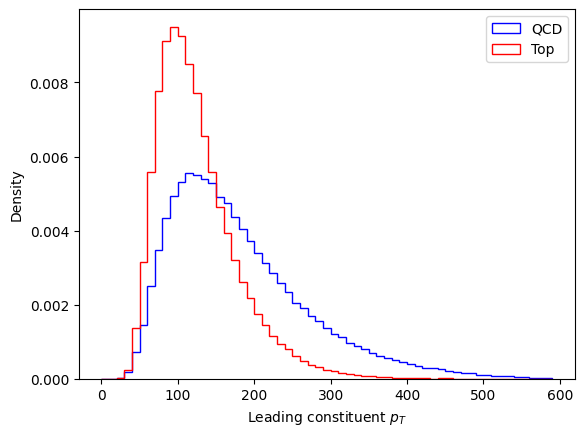

In [18]:
leading_pT = np.sqrt(train_features["PX_0"]**2+train_features["PY_0"]**2)
plt.hist(leading_pT[train_labels==0],bins=np.arange(0,600,10),histtype='step',color='blue',label='QCD',density=True)
plt.hist(leading_pT[train_labels==1],bins=np.arange(0,600,10),histtype='step',color='red',label='Top',density=True)
plt.legend(loc='upper right')
plt.ylabel('Density')
plt.xlabel('Leading constituent $p_T$')
plt.show()

Already we see a nice difference! The Top is softer than the background for the leading constituent. We can explain this by looking at the jet mass distribution. Because the cosntituents are zero-padded, we can obtain the total momentum by summing carefully. I prefer to work in numpy, so I'll transform everything to numpy.

In [19]:
train_features = train_features.to_numpy()
train_labels = train_labels.to_numpy()
top_momenta = top_momenta.to_numpy()

In [20]:
val_features = val_features.to_numpy()
val_labels = val_labels.to_numpy()
val_top_momenta = val_top_momenta.to_numpy()

In [21]:
totalE = np.sum(train_features[:,0:801:4],axis=1)
totalPX = np.sum(train_features[:,1:801:4],axis=1)
totalPY = np.sum(train_features[:,2:801:4],axis=1)
totalPZ = np.sum(train_features[:,3:801:4],axis=1)
print(totalE.shape,totalPX.shape,totalPY.shape,totalPZ.shape)

(500000,) (500000,) (500000,) (500000,)


In [22]:
total_mass = totalE**2-totalPX**2-totalPY**2-totalPZ**2
total_mass = np.where(total_mass > 0, np.sqrt(total_mass),0)

/tmp/ipykernel_26730/446176953.py:2: RuntimeWarning: invalid value encountered in sqrt
  total_mass = np.where(total_mass > 0, np.sqrt(total_mass),0)


In [23]:
total_mass

array([ 37.394016,  46.99734 ,  61.648197, ..., 172.09827 , 175.09676 ,
       198.52327 ], dtype=float32)

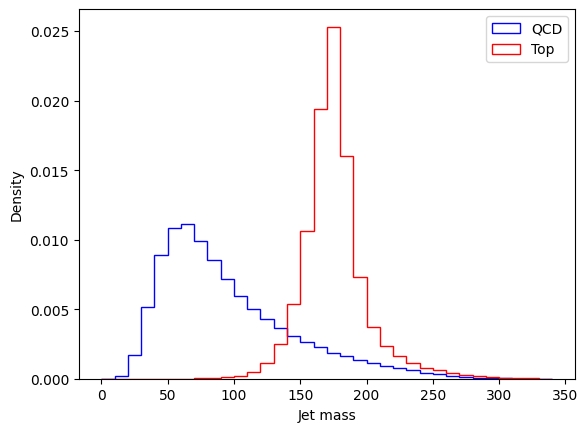

In [24]:
plt.hist(total_mass[train_labels==0],bins=np.arange(0,350,10),histtype='step',color='blue',label='QCD',density=True)
plt.hist(total_mass[train_labels==1],bins=np.arange(0,350,10),histtype='step',color='red',label='Top',density=True)
plt.legend(loc='upper right')
plt.ylabel('Density')
plt.xlabel('Jet mass')
plt.savefig('mass.png')
plt.show()

The jet mass is centered around the top mass for Top jets, while it's softer for QCD jets. Is there any relationship between mass and the leading constituent $p_T$?

In [25]:
scipy.stats.pearsonr(total_mass,leading_pT)

PearsonRResult(statistic=-0.47825946644683004, pvalue=0.0)

Text(0, 0.5, 'Leading $p_T$')

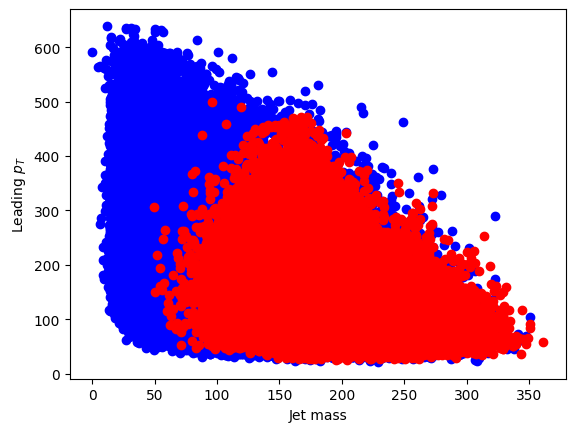

In [26]:
plt.scatter(total_mass[train_labels==0],leading_pT[train_labels==0],c='blue')
plt.scatter(total_mass[train_labels==1],leading_pT[train_labels==1],c='red')
plt.xlabel('Jet mass')
plt.ylabel('Leading $p_T$')

So, yes, but this doesn't look particularly useful. We can also look at other **global observables** . To do everything, its useful to compute the multiplicity. Because the energy is positive, we just need to check what's the first zero energy. We define a mask that can be used later on when using graphs.

In [27]:
train_mask = (train_features[:,0:801:4] > 0)
multiplicity = np.argmin(train_mask,axis=1)
print(multiplicity.shape)

(500000,)


In [28]:
val_mask = (val_features[:,0:801:4] > 0)
val_multiplicity = np.argmin(val_mask,axis=1)
print(val_multiplicity.shape)

(100000,)


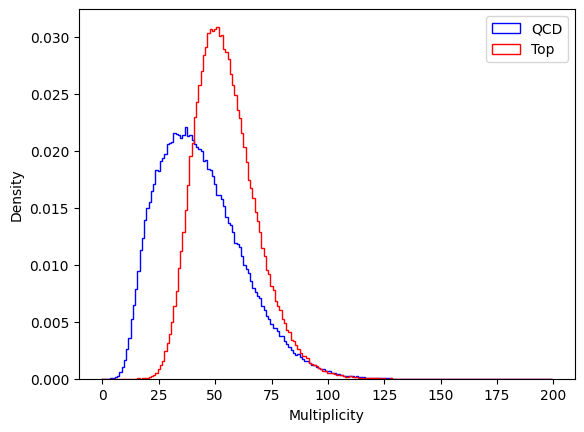

In [29]:
plt.hist(multiplicity[train_labels==0],bins=np.arange(-0.5,200.5,1),histtype='step',color='blue',label='QCD',density=True)
plt.hist(multiplicity[train_labels==1],bins=np.arange(-0.5,200.5,1),histtype='step',color='red',label='Top',density=True)
plt.legend(loc='upper right')
plt.ylabel('Density')
plt.xlabel('Multiplicity')
plt.savefig('multiplicity.png')
plt.show()

Text(0, 0.5, 'Multiplicity')

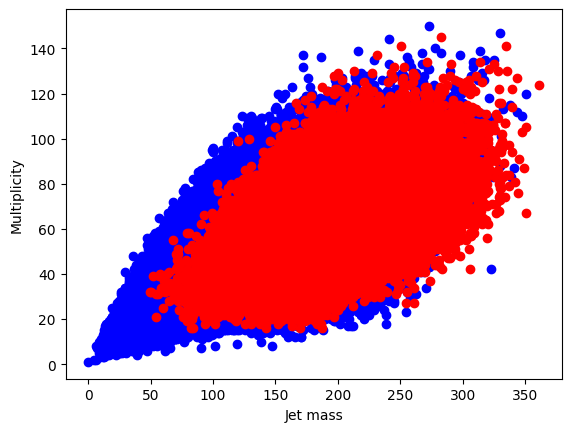

In [30]:
plt.scatter(total_mass[train_labels==0],multiplicity[train_labels==0],c='blue')
plt.scatter(total_mass[train_labels==1],multiplicity[train_labels==1],c='red')
plt.xlabel('Jet mass')
plt.ylabel('Multiplicity')

Let's compute the average $p_T$ (it's not the best observable but it's faster to compute). To do this, we need to move from (E,px,py,pz) to (pT,eta,phi,mass).

In [31]:
def Epxpypz_to_pTetaphimass(vec):
    E, px, py, pz = vec[0], vec[1], vec[2], vec[3]
    pT = np.sqrt(vec[1]**2+vec[2]**2)
    phi = np.arctan2(vec[2],vec[2])
    mass = np.sqrt(E**2-px**2-py**2-pz**2) if E**2-px**2-py**2-pz**2 > 0 else 0
    eta = np.arctanh(pz/np.sqrt(px**2+py**2+pz**2))
    return np.array([pT,eta,phi,mass])

In [32]:
av_pT = np.zeros(len(train_features))
for nevent in range(len(train_features)):
    av_pT[nevent]=np.mean(np.sqrt(train_features[nevent,1:4*multiplicity[nevent]:4]**2+train_features[nevent,2:4*multiplicity[nevent]:4]**2))

In [33]:
nevent,len(train_features)

(499999, 500000)

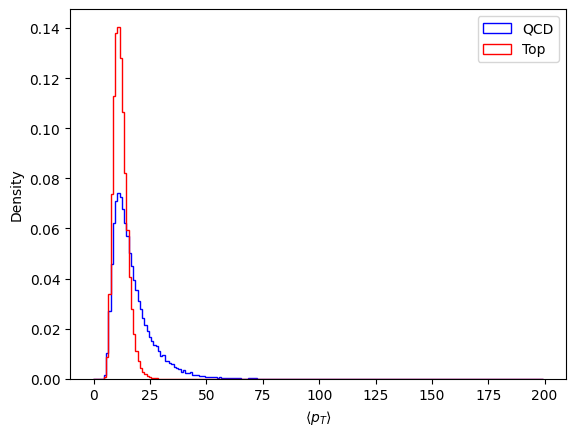

In [34]:
plt.hist(av_pT[train_labels==0],bins=np.arange(-0.5,200.5,1),histtype='step',color='blue',label='QCD',density=True)
plt.hist(av_pT[train_labels==1],bins=np.arange(-0.5,200.5,1),histtype='step',color='red',label='Top',density=True)
plt.legend(loc='upper right')
plt.ylabel('Density')
plt.xlabel(r'$\langle p_{T} \rangle$')
plt.savefig('av_pT.png')
plt.show()

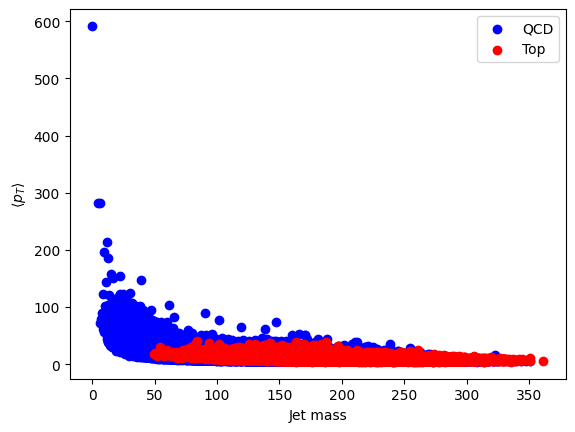

In [35]:
plt.scatter(total_mass[train_labels==0],av_pT[train_labels==0],c='blue',label='QCD')
plt.scatter(total_mass[train_labels==1],av_pT[train_labels==1],c='red',label='Top')
plt.legend(loc='upper right')
plt.xlabel('Jet mass')
plt.ylabel(r'$\langle p_{T} \rangle$')
plt.legend(loc='upper right')
plt.savefig('mass_av_pT.png')
plt.show()

# Baseline Classifier

We can use these two features to train a baseline classifier, let's use the simplest possible: a logistic regressor.

In [36]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [37]:
X_train = np.vstack([total_mass,av_pT]).T
print(X_train.shape)
lr.fit(X_train,train_labels)

(500000, 2)


LogisticRegression()

In [38]:
proba_lr = lr.predict_proba(X_train)[:,1]
assignment_lr = lr.predict(X_train) # it's just 0 if proba < 0.5 and 1 otherwise

In [39]:
proba_lr

array([0.01346516, 0.00784004, 0.0170622 , ..., 0.88837949, 0.82817595,
       0.92391527])

Let's see how the probability region looks

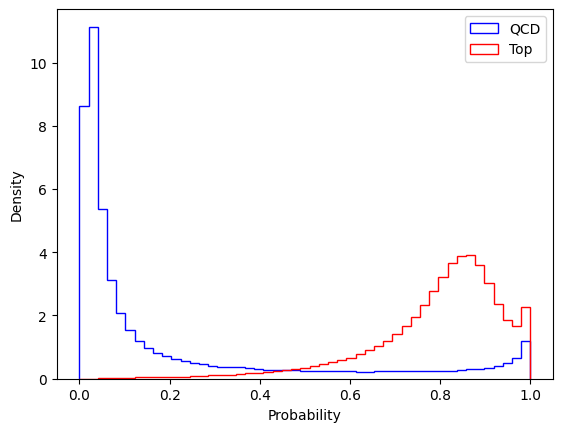

In [40]:
plt.hist(proba_lr[train_labels==0],bins=np.linspace(0,1,50),histtype='step',color='blue',label='QCD',density=True)
plt.hist(proba_lr[train_labels==1],bins=np.linspace(0,1,50),histtype='step',color='red',label='Top',density=True)
plt.legend(loc='upper right')
plt.ylabel('Density')
plt.xlabel('Probability')
plt.savefig('proba_lr.png')
plt.show()

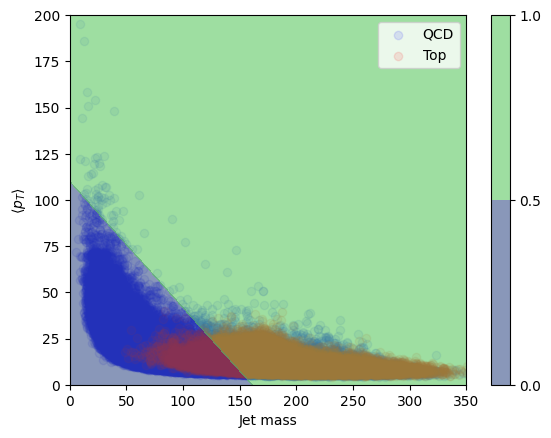

In [41]:
x1=np.linspace(0,350,100)
x2=np.linspace(0,200,100)
X1toplot,X2toplot=np.meshgrid(x1,x2)
#plt.xlim(0.0,0.2)
#plt.ylim(0.0,0.2)
plt.scatter(total_mass[train_labels==0],av_pT[train_labels==0],c='blue',alpha=0.1,label='QCD')
plt.scatter(total_mass[train_labels==1],av_pT[train_labels==1],c='red',alpha=0.1,label='Top')
Z=(np.asarray([lr.predict_proba(np.asarray([el[0],el[1]]).reshape(1,-1))[0,1] for el in np.c_[X1toplot.ravel(), X2toplot.ravel()]])).reshape(X1toplot.shape)

contour = plt.contourf(X1toplot,X2toplot,Z,levels=[0,0.5,1],alpha=0.6)
plt.colorbar(contour)


plt.xlim(0,350)
plt.ylim(0,200)
plt.xlabel('Jet mass')
plt.ylabel(r'$\langle p_{T} \rangle$')
plt.legend(loc='upper right')
plt.savefig('classifier_space_lr.png')
plt.show()

To evaluate the model, we need metrics. The logistic regressor outputs a probability and a hard assignment

In [44]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
print(accuracy_score(train_labels,assignment_lr),roc_auc_score(train_labels,proba_lr))

0.891444 0.910334261676372


Let's show the confusion matrix: row is true class, column predicted class.

In [45]:
confusion_matrix(train_labels,assignment_lr)

array([[210189,  40649],
       [ 13629, 235533]])

We see how many more QCD are tagged as tops than QCD as tops. This can be seen from the 2d plot above.

Let's plot the ROC Curve. There are many ways to plot, we'll do (FPR,TPR) so that up and left is better.

In [46]:
from sklearn.metrics import roc_curve
fpr_lr, tpr_lr, thr_lr = roc_curve(train_labels,proba_lr)

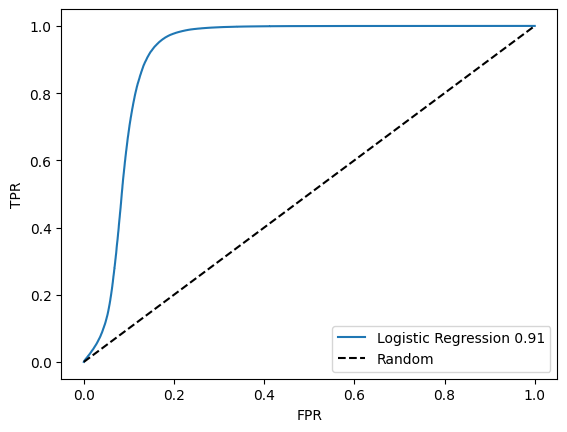

In [47]:
plt.plot(fpr_lr,tpr_lr,label='Logistic Regression '+str(round(roc_auc_score(train_labels,proba_lr),3)))
plt.plot(np.linspace(0,1,10),np.linspace(0,1,10),linestyle='dashed',color='black',label='Random')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='lower right')
plt.savefig('roc_curve.png')

Evaluate on validation

In [48]:
val_total_mass = np.sum(val_features[:,0:801:4],axis=1)**2-np.sum(val_features[:,1:801:4],axis=1)**2-np.sum(val_features[:,2:801:4],axis=1)**2-np.sum(val_features[:,3:801:4],axis=1)**2
val_total_mass = np.where(val_total_mass > 0, np.sqrt(val_total_mass),0)

In [49]:
val_total_mass

array([ 29.406233, 157.04945 , 226.96985 , ..., 173.36552 , 184.85028 ,
       130.6595  ], dtype=float32)

In [50]:
val_av_pT = np.zeros(len(val_features))
for nevent in range(len(val_features)):
    val_av_pT[nevent]=np.mean(np.sqrt(val_features[nevent,1:4*val_multiplicity[nevent]:4]**2+val_features[nevent,2:4*val_multiplicity[nevent]:4]**2))

In [51]:
X_val = np.vstack([val_total_mass,val_av_pT]).T
print(X_val.shape)
val_proba_lr = lr.predict_proba(X_val)[:,1]
val_assignmnet_lr = lr.predict(X_val)

(100000, 2)


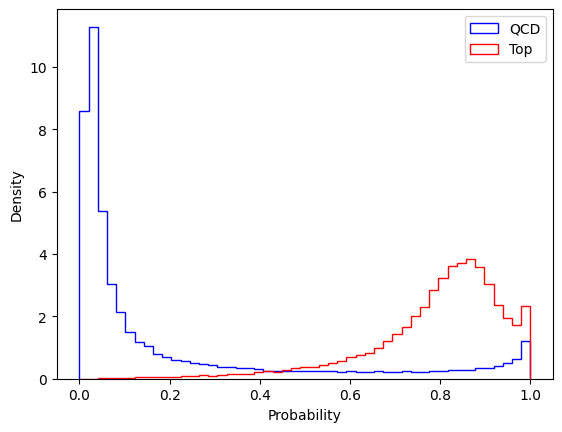

In [52]:
plt.hist(val_proba_lr[val_labels==0],bins=np.linspace(0,1,50),histtype='step',color='blue',label='QCD',density=True)
plt.hist(val_proba_lr[val_labels==1],bins=np.linspace(0,1,50),histtype='step',color='red',label='Top',density=True)
plt.legend(loc='upper right')
plt.ylabel('Density')
plt.xlabel('Probability')
plt.show()

In [53]:
print(accuracy_score(val_labels,val_assignmnet_lr),roc_auc_score(val_labels,val_proba_lr))

0.89114 0.9103360564526553


In [54]:
val_fpr_lr, val_tpr_lr, val_thr_lr = roc_curve(val_labels,val_proba_lr)

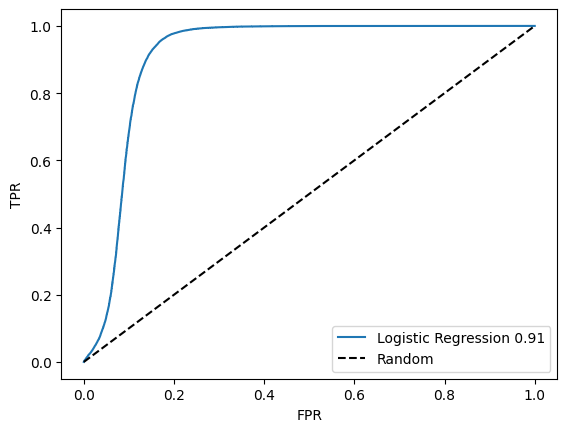

In [55]:
plt.plot(val_fpr_lr,val_tpr_lr,label='Logistic Regression '+str(round(roc_auc_score(val_labels,val_proba_lr),3)))
plt.plot(np.linspace(0,1,10),np.linspace(0,1,10),linestyle='dashed',color='black',label='Random')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='lower right')

## Exercise:

Redo this using the $C_{3}$ coefficient defined [here](https://arxiv.org/pdf/1305.0007) instead of the average $p_T$. It's much slower to compute, that's why we do not use it here.

# A home-made DeepSets classifier: [ParticleFlow Network](http://arxiv.org/abs/1810.05165)

We will do a ParticleFlow network but in 4-momenta space, without using the ($p_{T}$,$\eta$,$\phi$) representation. This will probably cost some performance, but it takes a bit longer to preprocess 1M events. You probably want to do that (and maybe try a CNN there as well!)

We'll define a custom Dataset and a custom Neural Network class in Pytorch.

Our dataset should have features, label and mask to indicate which particles are zero-padded

In [56]:
class CustomDataset(torch.utils.data.Dataset):
    """
    Joins the x and y into a dataset, so that it can be used by the pythorch syntax.
    """

    def __init__(self, x, y,m):
        self.x = torch.tensor(x).to(torch.float)
        self.y = torch.tensor(y).to(torch.float)
        self.m = torch.tensor(m).to(torch.float)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = [self.x[idx], self.y[idx],self.m[idx]]
        return sample

Let's standarize the dataset,otherwise the training gets really hard

In [57]:
maxE = np.max(train_features[:,0:801:4])
maxPX = np.max(np.abs(train_features[:,1:801:4]))
maxPY = np.max(np.abs(train_features[:,2:801:4]))
maxPZ = np.max(np.abs(train_features[:,3:801:4]))

meanE = np.mean(train_features[:,0:801:4].flatten()[train_mask.flatten()])
meanPX = np.mean(train_features[:,1:801:4].flatten()[train_mask.flatten()])
meanPY = np.mean(train_features[:,2:801:4].flatten()[train_mask.flatten()])
meanPZ = np.mean(train_features[:,3:801:4].flatten()[train_mask.flatten()])

stdE = np.std(train_features[:,0:801:4].flatten()[train_mask.flatten()])
stdPX = np.std(train_features[:,1:801:4].flatten()[train_mask.flatten()])
stdPY = np.std(train_features[:,2:801:4].flatten()[train_mask.flatten()])
stdPZ = np.std(train_features[:,3:801:4].flatten()[train_mask.flatten()])

In [58]:
print(maxE,maxPX,maxPY,maxPZ)

2183.8599 627.4477 634.30945 2094.1365


In [59]:
print(meanE,meanPX,meanPY,meanPZ)
print(stdE,stdPX,stdPY,stdPZ)

18.611986 -0.0044181882 -0.009700178 -0.00618418
49.125217 22.124771 22.137777 42.191326


In [60]:
'''
train_features[:,0:801:4]*=1/maxE
train_features[:,1:801:4]*=1/maxPX
train_features[:,2:801:4]*=1/maxPY
train_features[:,3:801:4]*=1/maxPZ
'''
train_features[:,0:801:4]=(train_features[:,0:801:4]-meanE)/stdE
train_features[:,1:801:4]=(train_features[:,1:801:4]-meanPX)/stdPX
train_features[:,2:801:4]=(train_features[:,2:801:4]-meanPY)/stdPY
train_features[:,3:801:4]=(train_features[:,3:801:4]-meanPZ)/stdPZ

Text(0.5, 0, 'Standarized Energy')

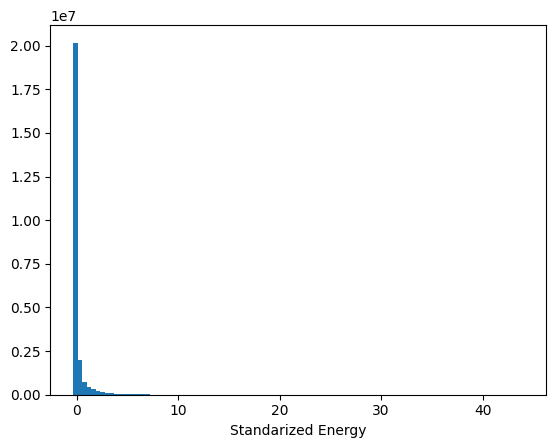

In [61]:
plt.hist(train_features[:,0:801:4].flatten()[train_mask.flatten()],bins=100);
plt.xlabel('Standarized Energy')

Text(0.5, 0, 'Standarized $p_x$')

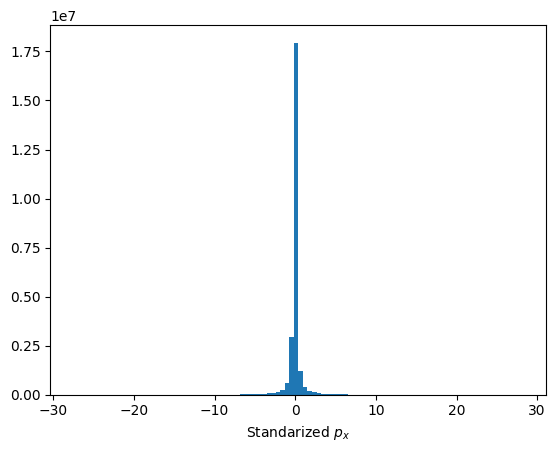

In [62]:
plt.hist(train_features[:,1:801:4].flatten()[train_mask.flatten()],bins=100);
plt.xlabel('Standarized $p_x$')

We standarize the validation dataset using the same parameters

In [63]:
val_features[:,0:801:4]=(val_features[:,0:801:4]-meanE)/stdE
val_features[:,1:801:4]=(val_features[:,1:801:4]-meanPX)/stdPX
val_features[:,2:801:4]=(val_features[:,2:801:4]-meanPY)/stdPY
val_features[:,3:801:4]=(val_features[:,3:801:4]-meanPZ)/stdPZ

In [64]:
train_torch = CustomDataset(train_features.reshape((len(train_features),200,4)),train_labels,train_mask)
val_torch = CustomDataset(val_features.reshape((len(val_features),200,4)),val_labels,val_mask)

Let's free some memory

In [65]:
'''
del train
del X_train
del val
del X_val
del train_features
del val_features
del train_mask
del val_mask
'''

'\ndel train\ndel X_train\ndel val\ndel X_val\ndel train_features\ndel val_features\ndel train_mask\ndel val_mask\n'

Our model consists of two neural networks, one evaluated per particle and one evaluated over all particles in an event

In [66]:
from torch import nn
from torch.nn.modules import Module
from torch.utils.data import DataLoader

In [67]:

# Define model
class PseudoParticleFlow(nn.Module):
    def __init__(self,dim_input=4,inner_dim=64,layers_Phi=[(64, nn.ReLU()),(64, nn.ReLU()),(64, nn.ReLU())],layers_F=[(64, nn.ReLU()),(64, nn.ReLU()),(64, nn.ReLU())]): # example of layers_data=[(layer1, nn.ReLU()), (layer2, nn.ReLU()), (output_size, nn.Sigmoid())]
        super(PseudoParticleFlow, self).__init__()
        self.flatten = nn.Flatten()
        self.Phi = nn.ModuleList()
        self.F = nn.ModuleList()
        self.input_size = dim_input  # Can be useful later ...
        self.inner_dim = inner_dim  # Can be useful later ...
        input_size = dim_input
        for size, activation in layers_Phi:
            self.Phi.append(nn.Linear(input_size, size))
            input_size = size  # For the next layer
            if activation is not None:
                assert isinstance(activation, Module), \
                    "Each tuples should contain a size (int) and a torch.nn.modules.Module."
                self.Phi.append(activation)
        self.Phi.append(nn.Linear(input_size, inner_dim))

        input_size = inner_dim
        for size, activation in layers_F:
            self.F.append(nn.Linear(input_size, size))
            input_size = size  # For the next layer
            if activation is not None:
                assert isinstance(activation, Module), \
                    "Each tuples should contain a size (int) and a torch.nn.modules.Module."
                self.F.append(activation)
        self.F.append(nn.Linear(input_size, 1))
        self.F.append(nn.Sigmoid())

    def forward(self, x,m):
        output = x
        for layer in self.Phi:
            output = layer(output)
            #print(output.shape)
        ### this uses the mask to remove zero-padded particles when performing the averaging
        output = torch.einsum('ijk,ij->ik',output,m)/(torch.einsum('ik,ik->i',m,m).unsqueeze(1))
        #output = torch.stack((torch.masked.masked_tensor(output[:,:,0], m),torch.masked.masked_tensor(output[:,:,0], m)),dim=-1)
        #print(output.shape)
        #output = torch.mean(output,1)
        #print(output.shape)
        for layer in self.F:
            output = layer(output)
            #print(output.shape)
        return output

    def latent(self, x,m):
        output = x
        for layer in self.Phi:
            output = layer(output)
            #print(output.shape)
        ### this uses the mask to remove zero-padded particles when performing the averaging
        output = torch.einsum('ijk,ij->ik',output,m)/(torch.einsum('ik,ik->i',m,m).unsqueeze(1))
        return output

    def proba_from_latent(self, ell):
        output = ell
        for layer in self.F:
            output = layer(output)
            #print(output.shape)
        return output

    def loss_function(self,y,t):
        #loss_fn = nn.MSELoss(reduction='mean')
        loss_fn = nn.BCELoss()

        return loss_fn(y,t)

    def reset_weights(self):
        for m in self.Phi:
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                m.reset_parameters()
        for m in self.F:
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                m.reset_parameters()

We can define training, testing and predicting functions

In [68]:
def train(model,optimizer,train_dataset,batch_size=1024):
    model.train()
    device = torch.device("cpu")#"cuda:0" if torch.cuda.is_available() else "cpu")
    train_dataset_batched = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
    total_loss = 0
    for batch, (X, y,M) in enumerate(train_dataset_batched):
        X, y, M  = X.to(device), y.to(device), M.to(device)
        #print(torch.mean(y))
        optimizer.zero_grad()  # Clear gradients.
        pred = model(X,M)[:,0]  # Forward pass.
        #print(pred.shape,y.shape)
        loss = model.loss_function(pred,y)  # Loss computation.
        loss.backward()  # Backward pass.
        optimizer.step()  # Update model parameters.
        total_loss += loss.item()

    return total_loss / len(train_dataset_batched.dataset)

def test(model, test_dataset,batch_size=1024):
    model.eval()
    device = torch.device("cpu")#"cuda:0" if torch.cuda.is_available() else "cpu")
    test_dataset_batched = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)
    total_loss = 0
    for batch, (X, y,M) in enumerate(test_dataset_batched):
        X, y, M  = X.to(device), y.to(device), M.to(device)
        pred = model(X,M)[:,0]  # Forward pass.
        loss = model.loss_function(pred,y)  # Loss computation.
        total_loss += loss.item()

    return total_loss / len(test_dataset_batched.dataset)

def predict_proba(model,test_dataset,batch_size=1024):
    model.eval()
    device = torch.device("cpu")#"cuda:0" if torch.cuda.is_available() else "cpu")
    test_dataset_batched = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)
    truths = np.zeros(len(test_dataset))
    preds = np.zeros(len(test_dataset))
    initial_index = 0
    final_index = 0
    for batch, (X, y,M) in enumerate(test_dataset_batched):
        final_index+=len(y)
        truths[initial_index:final_index]=y.detach().cpu().numpy()
        X, y, M  = X.to(device), y.to(device), M.to(device)
        pred = model(X,M)[:,0]  # Forward pass.
        preds[initial_index:final_index] = pred.detach().cpu().numpy()
        initial_index+=len(y)
    return truths, preds

def predict(model,test_dataset,batch_size=1024):
    model.eval()
    device = torch.device("cpu")#"cuda:0" if torch.cuda.is_available() else "cpu")
    test_dataset_batched = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)
    truths = np.zeros(len(test_dataset))
    preds = np.zeros(len(test_dataset))
    initial_index = 0
    final_index = 0
    for batch, (X, y,M) in enumerate(test_dataset_batched):
        final_index+=len(y)
        truths[initial_index:final_index]=y.detach().cpu().numpy()
        X, y, M  = X.to(device), y.to(device), M.to(device)
        pred = model(X,M)[:,0]  # Forward pass.
        preds[initial_index:final_index] = pred.detach().cpu().numpy()
        preds[initial_index:final_index] = np.where(preds[initial_index:final_index]>0.5,1,0)
        initial_index+=len(y)
    return truths, preds

def latent(model,test_dataset,batch_size=1024):
    model.eval()
    device = torch.device("cpu")#"cuda:0" if torch.cuda.is_available() else "cpu")
    test_dataset_batched = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)
    latent_variables = np.zeros((len(test_dataset),model.inner_dim))
    initial_index = 0
    final_index = 0
    for batch, (X, y,M) in enumerate(test_dataset_batched):
        final_index+=len(y)
        X, y, M  = X.to(device), y.to(device), M.to(device)
        pred = model.latent(X,M)  # Forward pass.
        latent_variables[initial_index:final_index] = pred.detach().cpu().numpy()
        initial_index+=len(y)
    return latent_variables


With this, we initialize our model. We can save and load models

In [69]:
model = PseudoParticleFlow()
model_path = 'saved_model.pth'
try:
    model.load_state_dict(torch.load(model_path))
    print("Loaded existing model")
except:
    print("New model")
device = torch.device("cpu")#"cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Loaded existing model


PseudoParticleFlow(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (Phi): ModuleList(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
  )
  (F): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

You can always start over by resetting the weights as commented below

In [70]:
#model.reset_weights()

We define the optimizer that we'll use for training

In [71]:
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Now the epochs

In [72]:
nepochs = 30
npatience = 5

In [73]:
print(torch.einsum('ik,ik->i',train_torch[:2][2],train_torch[:2][2]))
print(torch.einsum('ijk,ij->ik',train_torch[:2][0],train_torch[:2][2])/(torch.einsum('ik,ik->i',train_torch[:2][2],train_torch[:2][2]).unsqueeze(1)))

tensor([23., 43.])
tensor([[ 0.3905, -0.8942, -0.8179, -0.6296],
        [-0.0974,  0.4896,  0.3201, -0.1127]])


In [74]:
#totalE[0]/(maxE*multiplicity[0]),totalE[1]/(maxE*multiplicity[1])

And let's train. We'll use the validation to test to avoid overfitting (this you shouldn't do if you're actually using the validation dataset to select the best model, you should either cross-validate or separate the training into actual training and evaluation datasets)

In [ ]:
val_loss_aux = 1000
times = 0
for epoch in range(1, nepochs+1):
    loss = train(model, optimizer,train_torch,batch_size=1024)
    val_loss = test(model,val_torch,batch_size=1024)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.8f},Val Loss: {val_loss:.8f}, Learning Rate: {learning_rate:.6f}')
    if epoch == 0:
        val_loss_aux = val_loss
        times = 0
        continue

    if loss < val_loss_aux:
        val_loss_aux = val_loss
        times = 0
    else:
        times+=1

    if times == npatience:
        learning_rate*=0.1
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    if times == 2*npatience:
        break
    torch.save(model.state_dict(),model_path)


Once the model is slightly trained, we can obtain the predictions and do the same analysis

In [77]:
val_labels_NN, val_proba_NN = predict_proba(model,val_torch,batch_size=128)
val_assignmnet_NN = np.where(val_proba_NN>0.5,1,0)

In [78]:
confusion_matrix(val_labels_NN,val_assignmnet_NN)

array([[39974,  9836],
       [ 7765, 42425]])

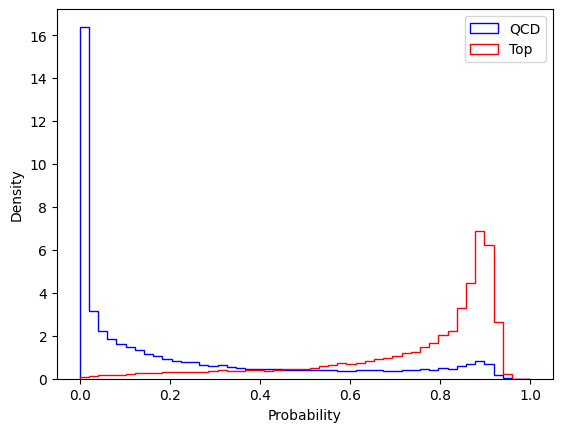

In [79]:
plt.hist(val_proba_NN[val_labels_NN==0],bins=np.linspace(0,1,50),histtype='step',color='blue',label='QCD',density=True)
plt.hist(val_proba_NN[val_labels_NN==1],bins=np.linspace(0,1,50),histtype='step',color='red',label='Top',density=True)
plt.legend(loc='upper right')
plt.ylabel('Density')
plt.xlabel('Probability')
plt.savefig('proba_NN.png')
plt.show()

In [80]:
print(accuracy_score(val_labels_NN,val_assignmnet_NN),roc_auc_score(val_labels_NN,val_proba_NN))

0.82399 0.8963330392490867


In [81]:
val_fpr_NN, val_tpr_NN, val_thr_NN = roc_curve(val_labels_NN,val_proba_NN)

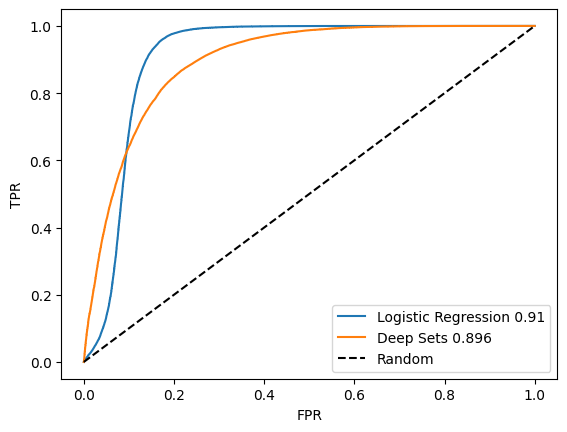

In [82]:
plt.plot(val_fpr_lr,val_tpr_lr,label='Logistic Regression '+str(round(roc_auc_score(val_labels,val_proba_lr),3)))
plt.plot(val_fpr_NN,val_tpr_NN,label='Deep Sets '+str(round(roc_auc_score(val_labels_NN,val_proba_NN),3)))
plt.plot(np.linspace(0,1,10),np.linspace(0,1,10),linestyle='dashed',color='black',label='Random')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='lower right')
plt.savefig('roc_NN.png')

Here the performance is not that impressive. This is because the architecture is not huge and we are not using the full dataset and training for a long time.

Now the interpretation is more difficult of course...

We can try to interpret the latent space

In [83]:
val_latent_variables_NN = latent(model,val_torch,batch_size=128)

In [84]:
val_latent_variables_NN.shape

(100000, 64)

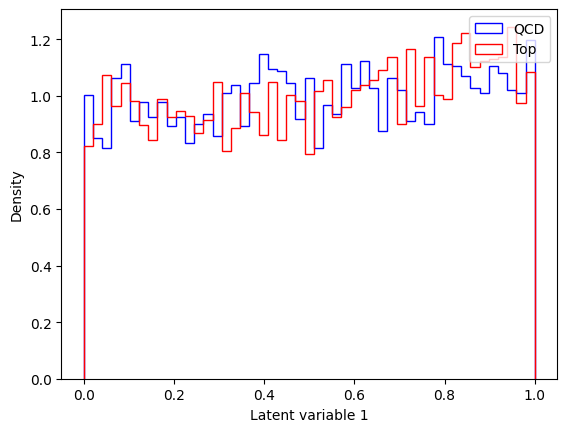

In [85]:
plt.hist(val_latent_variables_NN[val_labels_NN==0,0],bins=np.linspace(0,1,50),histtype='step',color='blue',label='QCD',density=True)
plt.hist(val_latent_variables_NN[val_labels_NN==1,0],bins=np.linspace(0,1,50),histtype='step',color='red',label='Top',density=True)
plt.legend(loc='upper right')
plt.ylabel('Density')
plt.xlabel('Latent variable 1')
plt.savefig('latent_1.png')
plt.show()

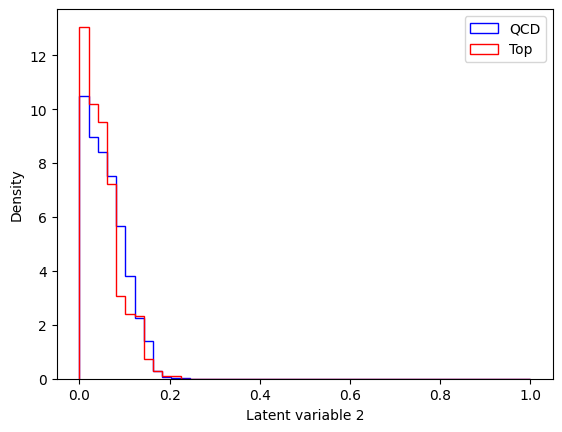

In [86]:
plt.hist(val_latent_variables_NN[val_labels_NN==0,1],bins=np.linspace(0,1,50),histtype='step',color='blue',label='QCD',density=True)
plt.hist(val_latent_variables_NN[val_labels_NN==1,1],bins=np.linspace(0,1,50),histtype='step',color='red',label='Top',density=True)
plt.legend(loc='upper right')
plt.ylabel('Density')
plt.xlabel('Latent variable 2')
plt.savefig('latent_2.png')
plt.show()

In [87]:
for nlatent_dim in range(model.inner_dim):
  plt.hist(val_latent_variables_NN[val_labels_NN==0,nlatent_dim],bins=np.linspace(0,1,50),histtype='step',color='blue',label='QCD',density=True)
  plt.hist(val_latent_variables_NN[val_labels_NN==1,nlatent_dim],bins=np.linspace(0,1,50),histtype='step',color='red',label='Top',density=True)
  plt.legend(loc='upper right')
  plt.ylabel('Density')
  plt.xlabel('Latent variable '+str(nlatent_dim+1))
  #plt.savefig('latent_'+str(nlatent_dim+1)+'.png')
  plt.clf()

/home/mszewc/.local/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


<Figure size 640x480 with 0 Axes>

In [88]:
for nlatent_dim1 in range(model.inner_dim):
    for nlatent_dim2 in range(nlatent_dim1+1,model.inner_dim):
        if nlatent_dim1>2 or nlatent_dim2>3:
            break
        plt.scatter(val_latent_variables_NN[val_labels_NN==0,nlatent_dim1],val_latent_variables_NN[val_labels_NN==0,nlatent_dim2],c='blue',alpha=0.1,label='QCD')
        plt.scatter(val_latent_variables_NN[val_labels_NN==1,nlatent_dim1],val_latent_variables_NN[val_labels_NN==1,nlatent_dim2],c='red',alpha=0.1,label='Top')
    
    
    
        #plt.xlim(0,1)
        #plt.ylim(0,1)
        plt.xlabel('Latent variable '+str(nlatent_dim1+1))
        plt.ylabel('Latent variable '+str(nlatent_dim2+1))
        plt.legend(loc='upper right')
        #plt.savefig('classifier_space_NN'+str(nlatent_dim1+1)+'_'+str(nlatent_dim2+1)+'.png')
        plt.clf()

<Figure size 640x480 with 0 Axes>

If the latent dimension is equal to 2, we can do the same plots as before

In [89]:
if model.inner_dim == 2:
    x1=np.linspace(0,1,100)
    x2=np.linspace(0,1,100)
    X1toplot,X2toplot=np.meshgrid(x1,x2)
    #plt.xlim(0.0,0.2)
    #plt.ylim(0.0,0.2)
    plt.scatter(val_latent_variables_NN[val_labels_NN==0,0],val_latent_variables_NN[val_labels_NN==0,1],c='blue',alpha=0.1,label='QCD')
    plt.scatter(val_latent_variables_NN[val_labels_NN==1,0],val_latent_variables_NN[val_labels_NN==1,1],c='red',alpha=0.1,label='Top')
    Z=(np.asarray([model.proba_from_latent(torch.tensor(np.asarray([el[0],el[1]]).reshape(1,-1),dtype=torch.float)).detach().numpy()[0] for el in np.c_[X1toplot.ravel(), X2toplot.ravel()]])).reshape(X1toplot.shape)
    
    contour = plt.contourf(X1toplot,X2toplot,Z,levels=[0,0.5,1],alpha=0.6)
    plt.colorbar(contour)
    
    
    #plt.xlim(0,1)
    #plt.ylim(0,1)
    plt.xlabel('Latent variable 1')
    plt.ylabel('Latent variable 2')
    plt.legend(loc='upper right')
    plt.savefig('classifier_space_NN.png')
    plt.show()

# Exercises

* Repeat this with different inner dimension (don't break your computer!). To explore the latent space, you can use tools like t-SNE or PCA
* Reframe this as a regression task, learn the $C_3$ coefficient from the constituents. This could use the same architecture but a different loss function.
* Use a similar architecture for a GAN to generate tops or QCD jets (or both! but you'll find differences).